Importing modules

In [3]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn import metrics as sklearn_metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
import xgboost as xgb

from statistics import median, mean
from statsmodels.stats.contingency_tables import Table2x2
import statistics

from math import fabs
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

from scipy.stats import chi2_contingency
from sklearn.metrics import roc_auc_score


Setting constants

In [4]:
path_dataset = r'DataSet.xlsx'
path_table_continuous_predictors = r'Continuous.txt'
path_table_categorical_predictors = r'Сategory.txt'
path_table_functional_characteristics = r'Table1.xlsx'
path_table_logistic_regression = r'Table2.xlsx'
path_table_random_forest = r'Table3.xlsx'
path_table_stochastic_gradient_boosting = r'Table4.xlsx'
path_table_risk_factor = r'Table5.xlsx'


Data set loading and preprocessing

In [ ]:
def loadPredicts( dataPath ):
    with open( dataPath, 'r') as dataPath_file:
        predicts = []
        for string in dataPath_file:
            string = string.replace("\n",'')
            predicts.append( string )
    return predicts


def oneHotEncoder( dataset, сategory_predicts ):
    result_сategory_predicts = []
    print("\tContinuous predictors loaded:")
    for predictor in сategory_predicts:
            dataset_dummies = pd.get_dummies(dataset[predictor],prefix=predictor,dummy_na=True)
            columns = dataset_dummies.columns
            dataset_dummies.loc[dataset_dummies[predictor+"_nan"] == 1, columns] = None
            del dataset_dummies[predictor+"_nan"]
            dataset = pd.concat([dataset,dataset_dummies],axis=1)
            print( "\tThe predictor is loaded \"" + predictor + "\" which is divided into predictors:" )
            for column in dataset_dummies.columns:
                print("\t\t"+column)
                result_сategory_predicts.append( column )
    return {"dataset":dataset, "сategory_predicts":result_сategory_predicts}

def getPredictArrays( dataset, path_table_continuous_predictors = path_table_continuous_predictors, path_table_categorical_predictors = path_table_categorical_predictors ):

    print("Predictor loading has started.\n\tContinuous predictors loaded:")
    continuous_predictors = loadPredicts(path_table_continuous_predictors)
    for predictor in continuous_predictors:
        print("\t"+predictor)
        dataset.loc[((dataset[predictor])=="Yes") ,(predictor)]=1
        dataset.loc[((dataset[predictor])=="No") ,(predictor)]=0
        dataset = dataset.astype({predictor: "float64"})

    сontinuous_predictors = loadPredicts( path_table_categorical_predictors )
    result = oneHotEncoder( dataset, сontinuous_predictors )                    #Converting categorical variables to binary
    predictor_arrays = { "Continuous":continuous_predictors,"Сategory":result["сategory_predicts"] }
    return {"predictor_arrays": predictor_arrays,"dataset":result["dataset"] }

dataset = pd.read_excel(path_dataset)
result = getPredictArrays(dataset)
predictor_arrays = result["predictor_arrays"]
dataset = result["dataset"]


Formation of the "Functional characteristics" table

In [6]:
#Processing categorical permanent
def getTableFunctionalCharacteristicsObject( dataset, x_array, y):

  data_d = dataset.loc[dataset[y]==1]
  data_s = dataset.loc[dataset[y]==0]
  table = []
  for x in x_array:
    try:

      count_gruup_1 = 0
      procent_gruup_1 = 0
      count_gruup_0 = 0
      procent_gruup_0 = 0
      odd_ratio_true = 0
      confint = [0,0]
      p_value_true = 0
      odds_ratio = 0.0
      count_gruup_1_1 = 0

      count_gruup_1 = len(data_d.loc[(data_d[x]==1)][x].dropna()) #Calculation of the absolute number of dead patients
      procent_gruup_1 = count_gruup_1/len(data_d[y].dropna())*100 #Calculation of the relative number of dead patients


      count_gruup_0 = len(data_s.loc[data_s[x]==1][x].dropna())   #Calculation of the absolute number of surviving patients
      procent_gruup_0 = count_gruup_0/len(data_s[y].dropna())*100 #Calculation of the relative number of surviving patients

      x_y = pd.DataFrame()
      x_y[x] = dataset[x]
      x_y[y] = dataset[y]
      x_y[x+"binary"] = 0
      x_y.loc[((x_y[x])==1),(x+"binary")]=1
      x_y = x_y.dropna()
      data_crosstab = pd.crosstab(x_y[y],
                                  x_y[x+"binary"])

      if( data_crosstab.shape == (2, 2) ):                  #Calculation of the p-value of the x^2 test and OR
                chi2, p_value_true, df, expected = stats.chi2_contingency(data_crosstab)
                odd_ratio, p = stats.fisher_exact(data_crosstab)
                table2x2 = Table2x2(data_crosstab, shift_zeros=False)
                confint = table2x2.oddsratio_confint()

      else:
                print( "Error -",data_crosstab.shape)

      if p_value_true < 0.000001:
        p_value_true =  "<0.000001"
      else:
        p_value_true =  "{0:.6f}".format(p_value_true)

      count_gruup_1_1 = len(x_y.loc[ x_y[ y ] == 1 ])

      result =  {
                  "Predictor":x,
                  "Number of patients in group 1":count_gruup_1_1,
                  "Group 1 (95% CI)":"{0:.2f} ({1:.2f}%)".format(count_gruup_1,procent_gruup_1),
                  "Group 0 (95% CI)":"{0:.2f} ({1:.2f}%)".format(count_gruup_0,procent_gruup_0),
                  "Group 1 (Q1;Q3)":"{0:.2f} ({1:.2f}%)".format(count_gruup_1,procent_gruup_1),
                  "Group 0 (Q1;Q3)":"{0:.2f} ({1:.2f}%)".format(count_gruup_0,procent_gruup_0),
                  "OR CI(95%)":"{0:.2} [{1:.2f}; {2:.2f}]".format(odds_ratio,confint[0],confint[1]),
                  "p-value":p_value_true,
                }
      print(x," is load")
    except Exception as e:
          print(x," - ",e)
          result =  {
                      "Predictor":x,
                      "Number of patients in group 1":count_gruup_1_1,
                      "Group 1 (95% CI)":"{0:.2f} ({1:.2f}%)".format(count_gruup_1,procent_gruup_1),
                      "Group 0 (95% CI)":"{0:.2f} ({1:.2f}%)".format(count_gruup_0,procent_gruup_0),
                      "Group 1 (Q1;Q3)":"{0:.2f} ({1:.2f}%)".format(count_gruup_1,procent_gruup_1),
                      "Group 0 (Q1;Q3)":"{0:.2f} ({1:.2f}%)".format(count_gruup_0,procent_gruup_0),
                      "OR CI(95%)":"{0:.2} [{1:.2f}; {2:.2f}]".format(odds_ratio,confint[0],confint[1]),
                      "p-value":p_value_true,
                    }
    table.append(result)
  return table

#Processing of continuous permanent
def getTableFunctionalCharacteristicsInt( dataset, x_array, y):

  data_d = dataset.loc[dataset[y]==1]
  data_s = dataset.loc[dataset[y]==0]
  table = []
  for x in x_array:
    try:
      median_d = 0
      median_d_interval = [0,0]
      median_s  = 0
      median_s_interval = [0,0]
      pvalue  = 0
      count_gruup_1 = 0
      median_d = data_d[x].dropna().median() #Median and 95% CI of dead patients
      median_d_interval = stats.t.interval(alpha= 0.95 , df=len(data_d[x].dropna())-1, loc=data_d[x].dropna().median(), scale=stats.sem(data_d[x].dropna()))
      median_s = data_s[x].dropna().median() #Median and 95% CI of surviving patients
      median_s_interval = stats.t.interval(alpha= 0.95 , df=len(data_s[x].dropna())-1, loc=data_s[x].dropna().median(), scale=stats.sem(data_s[x].dropna()))
                                             #Q1 and Q2 of dead and surviving patients
      percentile_d = np.percentile( data_d[x].dropna(), [25, 75])
      percentile_s = np.percentile( data_s[x].dropna(), [25, 75])

      x_y = pd.DataFrame()
      x_y[x] = dataset[x]
      x_y[y] = dataset[y]
      x_y = x_y.dropna()                     #Calculate the p-value of the mannwhitneyu test
      pvalue = stats.mannwhitneyu( x_y.loc[(x_y[y]==1),(x)],x_y.loc[(x_y[y]==0),(x)] ).pvalue
      if pvalue < 0.000001:
        pvalue =  "<0.000001"
      else:
        pvalue =  "{0:.6f}".format(pvalue)

      count_gruup_1 = len(x_y.loc[ x_y[y] == 1 ] )
      result =  {
                  "Predictor":x,
                  "Number of patients in group 1":count_gruup_1,
                  "Group 1 (95% CI)":"{0:.2f} ({1:.3f}; {2:.3f})".format(float(median_d),float(median_d_interval[0]),float(median_d_interval[1])),
                  "Group 0 (95% CI)":"{0:.2f} ({1:.3f}; {2:.3f})".format(float(median_s),float(median_s_interval[0]),float(median_s_interval[1])),
                  "Group 1 (Q1;Q3)":"{0:.2f} ({1:.3f}; {2:.3f})".format(float(median_d),float(percentile_d[0]),float(percentile_d[1])),
                  "Group 0 (Q1;Q3)":"{0:.2f} ({1:.3f}; {2:.3f})".format(float(median_s),float(percentile_s[0]),float(percentile_s[1])),
                  "OR CI(95%)":" - ",
                  "p-value":pvalue,
                }
      print(x," is load")
    except Exception as e:
          print(x," - ",e)
          result =  {
                      "Predictor":x,
                      "Number of patients in group 1":count_gruup_1,
                      "Group 1 (95% CI)":"{0:.2f} ({1:.3f}; {2:.3f})".format(float(median_d),float(median_d_interval[0]),float(median_d_interval[1])),
                      "Group 0 (95% CI)":"{0:.2f} ({1:.3f}; {2:.3f})".format(float(median_s),float(median_s_interval[0]),float(median_s_interval[1])),
                      "Group 1 (Q1;Q3)":"{0:.2f} ({1:.3f}; {2:.3f})".format(float(median_d),float(percentile_d[0]),float(percentile_d[1])),
                      "Group 0 (Q1;Q3)":"{0:.2f} ({1:.3f}; {2:.3f})".format(float(median_s),float(percentile_s[0]),float(percentile_s[1])),
                      "OR CI(95%)":" - ",
                      "p-value":pvalue,
                    }
    table.append(result)
  return table


def getTableFunctionalCharacteristics( dataset, x_array, y ):
    table_int = getTableFunctionalCharacteristicsInt( dataset, x_array['Continuous'], y )
    table_obj = getTableFunctionalCharacteristicsObject( dataset,x_array['Сategory'], y )
    table = pd.DataFrame([*table_int, *table_obj])
    return table

table = getTableFunctionalCharacteristics( dataset, predictor_arrays, "Dead")
table.to_excel(path_table_functional_characteristics)

<ipython-input-6-f4d380dfea06>:92: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  median_d_interval = stats.t.interval(alpha= 0.95 , df=len(data_d[x].dropna())-1, loc=data_d[x].dropna().median(), scale=stats.sem(data_d[x].dropna()))
<ipython-input-6-f4d380dfea06>:94: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  median_s_interval = stats.t.interval(alpha= 0.95 , df=len(data_s[x].dropna())-1, loc=data_s[x].dropna().median(), scale=stats.sem(data_s[x].dropna()))
<ipython-input-6-f4d380dfea06>:92: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
 

Age  is load
Height  is load
Weight  is load
BMI  is load
SBP  is load
DBP  is load
PBP  is load
HR  is load
Cr  is load
EF LV  is load
EDV  is load
ESV  is load
LVRWTI  is load
LVRMI  is load
SPAP  is load


<ipython-input-6-f4d380dfea06>:92: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  median_d_interval = stats.t.interval(alpha= 0.95 , df=len(data_d[x].dropna())-1, loc=data_d[x].dropna().median(), scale=stats.sem(data_d[x].dropna()))
<ipython-input-6-f4d380dfea06>:94: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  median_s_interval = stats.t.interval(alpha= 0.95 , df=len(data_s[x].dropna())-1, loc=data_s[x].dropna().median(), scale=stats.sem(data_s[x].dropna()))
<ipython-input-6-f4d380dfea06>:92: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
 

La1  is load
La2  is load
Ra1  is load
Ra2  is load
WBC  is load
NEUT  is load
LYM  is load
EOS  is load
RBC  is load
Hb  is load
PLT  is load
Glu  is load
Urea  is load
PCT  is load


<ipython-input-6-f4d380dfea06>:94: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  median_s_interval = stats.t.interval(alpha= 0.95 , df=len(data_s[x].dropna())-1, loc=data_s[x].dropna().median(), scale=stats.sem(data_s[x].dropna()))
<ipython-input-6-f4d380dfea06>:92: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  median_d_interval = stats.t.interval(alpha= 0.95 , df=len(data_d[x].dropna())-1, loc=data_d[x].dropna().median(), scale=stats.sem(data_d[x].dropna()))
<ipython-input-6-f4d380dfea06>:94: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
 

PI  is load
INR  is load
TT  is load
APTT  is load
Sex_M  is load
Sex_W  is load
Killip class_0.0  is load
Killip class_1.0  is load
Killip class_2.0  is load
Killip class_3.0  is load
Killip class_4.0  is load
Form STEMI_Back  is load
Form STEMI_Front  is load
AFib_No  is load
AFib_Yes  is load
Diabetes_No  is load
Diabetes_Yes  is load
CKD_No  is load
CKD_Yes  is load
aMI_No  is load
aMI_Yes  is load
COPD_No  is load
COPD_Yes  is load


Declaration of the functions required for cross-validation and training of models

In [ ]:
from logging import exception

def emptyFunction( yTrain, xTrain, yTest, xTest, a = 0, hp = {} ):
    return {
              "a":0,
              "ppv":0,
              "npv":0,
              "se":0,
              "sp":0,
              "auc":0,
              "acc":0,
              "f1":0,
              "brier_score":0,
          }
#Function for cross-validation of various models
def crossValidationTestModel( dataset, y, parameters, getModel=emptyFunction, numberKF=10, a_base = 0, number_split=500 ):

    x = parameters["predictors"]
    hp = parameters["hp"]
    mads = []
    try:
        #Removing voids
        x.append(y)
        dataset = dataset[x]
        dataset = dataset.dropna()
        x.remove(y)

        if ( len(dataset.loc[((dataset[y])==1)])<=constants.class_threshold ):
            raise ValueError('Patients with predictor "{0}"<={1}'.format(y,constants.class_threshold))
        #Data normalization
        scaler = preprocessing.MinMaxScaler()
        xData = dataset[x].values
        scaler.fit(xData)
        yData = dataset[y].values

        auc_array = []
        f1_array = []
        sensitivity_array = []
        specificity_array = []
        ppv_array = []
        npv_array = []

        auc_array_reult = []
        f1_array_reult = []
        sensitivity_array_reult = []
        specificity_array_reult = []
        ppv_array_reult = []
        npv_array_reult = []

        for random_state in range( 1,number_split ):
                                                            #Separation of data into a sample for cross-validation and final testing
          samples = getStratifiedSampling(  xData,yData,
                                            train_size=0.8, random_state = random_state )

          xTrain = samples["xTrain"]
          xTest = samples["xTest"]
          yTrain = samples["yTrain"]
          yTest = samples["yTest"]


          if( a_base == 0 ):
            result = getModel(yTrain, xTrain, yTrain, xTrain, hp = hp )
            a_base = result["metrics"]['a']
                                                            #Cross-validation
          skf = StratifiedKFold(numberKF)

          for i, (train_index, test_index) in enumerate(skf.split(xTrain,yTrain)):

            xTrainCV = xTrain[train_index]
            xTestCV = xTrain[test_index]
            yTrainCV = yTrain[train_index]
            yTestCV = yTrain[test_index]

            metrics = getModel( yTrainCV, xTrainCV, yTestCV, xTestCV, a = a_base, hp = hp )["metrics"]
            sensitivity_array.append(metrics["se"])
            specificity_array.append(metrics["sp"])
            auc_array.append(metrics["auc"])
            f1_array.append(metrics["f1"])
            ppv_array.append(metrics["ppv"])
            npv_array.append(metrics["npv"])
                                                            #Final testing
          result = getModel( yTrain, xTrain, yTest, xTest, a = a_base, hp = hp )
          metrics = result["metrics"]

          sensitivity_array_reult.append(metrics["se"])
          specificity_array_reult.append(metrics["sp"])
          auc_array_reult.append(metrics["auc"])
          f1_array_reult.append(metrics["f1"])
          ppv_array_reult.append(metrics["ppv"])
          npv_array_reult.append(metrics["npv"])

          model = result["model"]
                                                            #Model and data recording
          mads.append(
              {
                  "model":model,
                  "learning_dataset":{
                                      "x":xTrain,
                                      "y":yTrain
                                      },
                  "test_dataset":{
                                      "x":xTest,
                                      "y":yTest
                                      },
                  "metrics":metrics,
                  "predictors":x,
              }
           )
                                                            #Averaging estimates
        auc_di = stats.t.interval(confidence= 0.95 , df=len(auc_array)-1, loc=statistics.median(auc_array), scale=stats.sem(auc_array))
        sensitivity_di = stats.t.interval(confidence= 0.95 , df=len(sensitivity_array)-1, loc=statistics.median(sensitivity_array), scale=stats.sem(sensitivity_array))
        specificity_di = stats.t.interval(confidence= 0.95 , df=len(specificity_array)-1, loc=statistics.median(specificity_array), scale=stats.sem(specificity_array))
        f1_di = stats.t.interval(confidence= 0.95 , df=len(f1_array)-1, loc=statistics.median(f1_array), scale=stats.sem(f1_array))
        ppv_di = stats.t.interval(confidence= 0.95 , df=len(ppv_array)-1, loc=statistics.median(ppv_array), scale=stats.sem(ppv_array))
        npv_di = stats.t.interval(confidence= 0.95 , df=len(npv_array)-1, loc=statistics.median(npv_array), scale=stats.sem(npv_array))

        auc_reult_di = stats.t.interval(confidence= 0.95 , df=len(auc_array_reult)-1, loc=statistics.median(auc_array_reult), scale=stats.sem(auc_array_reult))
        sensitivity_reult_di = stats.t.interval(confidence= 0.95 , df=len(sensitivity_array_reult)-1, loc=statistics.median(sensitivity_array_reult), scale=stats.sem(sensitivity_array_reult))
        specificity_reult_di = stats.t.interval(confidence= 0.95 , df=len(specificity_array_reult)-1, loc=statistics.median(specificity_array_reult), scale=stats.sem(specificity_array_reult))
        f1_reult_di = stats.t.interval(confidence= 0.95 , df=len(f1_array_reult)-1, loc=statistics.median(f1_array_reult), scale=stats.sem(f1_array_reult))
        ppv_reult_di = stats.t.interval(confidence= 0.95 , df=len(ppv_array_reult)-1, loc=statistics.median(ppv_array_reult), scale=stats.sem(ppv_array_reult))
        npv_reult_di = stats.t.interval(confidence= 0.95 , df=len(npv_array_reult)-1, loc=statistics.median(npv_array_reult), scale=stats.sem(npv_array_reult))

        dead_count = sum( [1 for x in yData if x==True] )
        live_count = len(yData)-dead_count

        return {  "Survivors/Deceased":"{0}/{1}".format(live_count,dead_count),
                  "Cut-off threshold":"{0:.3f}".format(a_base),
                  "Cross-Validation - Auc":statistics.median(auc_array),
                  "Cross-Validation - Auc ДИ":"{0:.3f} [{1:.3f}; {2:.3f}]".format(statistics.median(auc_array),auc_di[0],auc_di[1]),
                  "Cross-Validation - F1":"{0:.3f} [{1:.3f}; {2:.3f}]".format(statistics.median(f1_array),f1_di[0],f1_di[1]),
                  "Cross-Validation - PPV":"{0:.3f} [{1:.3f}; {2:.3f}]".format(statistics.median(ppv_di),ppv_di[0],ppv_di[1]),
                  "Cross-Validation - NPV":"{0:.3f} [{1:.3f}; {2:.3f}]".format(statistics.median(npv_di),npv_di[0],npv_di[1]),
                  "Cross-Validation - Se":"{0:.3f} [{1:.3f}; {2:.3f}]".format(statistics.median(sensitivity_array),sensitivity_di[0],sensitivity_di[1]),
                  "Cross-Validation - Sp":"{0:.3f} [{1:.3f}; {2:.3f}]".format(statistics.median(specificity_array),specificity_di[0],specificity_di[1]),
                  "Test - Auc":statistics.median(auc_array_reult),
                  "Test - Auc ДИ":"{0:.3f} [{1:.3f}; {2:.3f}]".format(statistics.median(auc_array_reult),auc_reult_di[0],auc_reult_di[1]),
                  "Test - F1":"{0:.3f} [{1:.3f}; {2:.3f}]".format(statistics.median(f1_array_reult),f1_reult_di[0],f1_reult_di[1]),
                  "Test - PPV":"{0:.3f} [{1:.3f}; {2:.3f}]".format(statistics.median(ppv_array_reult),ppv_reult_di[0],ppv_reult_di[1]),
                  "Test - NPV":"{0:.3f} [{1:.3f}; {2:.3f}]".format(statistics.median(npv_array_reult),npv_reult_di[0],npv_reult_di[1]),
                  "Test - Se":"{0:.3f} [{1:.3f}; {2:.3f}]".format(statistics.median(sensitivity_array_reult),sensitivity_reult_di[0],sensitivity_reult_di[1]),
                  "Test - Sp":"{0:.3f} [{1:.3f}; {2:.3f}]".format(statistics.median(specificity_array_reult),specificity_reult_di[0],specificity_reult_di[1]),
                  "Initial data of the model": mads
                  }

    except Exception as e:
        print(e)
        return { }
                                              #Getting a stratified sample
def getStratifiedSampling( x, y, train_size=0.5, random_state = 0 ):

    xTrain, xTest, yTrain, yTest = train_test_split(x,y,
                                                          train_size=train_size,
                                                          stratify=y,
                                                          random_state = random_state)
    samples = {
                "xTrain":xTrain,
                "xTest":xTest,
                "yTrain":yTrain,
                "yTest":yTest,
                }

    return samples
                                              #Calculation of the cut-off threshold
def getCutOffThreshold( yProb , data, isPrint = False ):
    a=0
    l=10000000000

    step = 1/(max(len(data),len(yProb)))

    arrayX = []
    arrayYY = []
    arrayYN = []

    while a<=1:

        yPred = (np.where( yProb > a, 1, 0 ))
        tn, fp, fn, tp = sklearn_metrics.confusion_matrix( data, yPred ).ravel()

        if( tp+fn != 0  ):
          sensitivity = tp/(tp+fn)
        else:
          sensitivity = 0

        if( tn+fp != 0  ):
          specificity = tn/(tn+fp)
        else:
          specificity = 0
                                              #If the difference between Se and Sp is exceeded, then the threshold is found
        if( fabs(sensitivity-specificity)<l ):
            alpha = a
            l = fabs(sensitivity-specificity)
        if( fabs(sensitivity-specificity)>l ):
            break
        a=a+step

        if( isPrint ):
          arrayX.append(a)
          arrayYY.append( sensitivity )
          arrayYN.append( specificity )



    if( isPrint ):
      plt.plot(arrayX,arrayYY,label="Se")
      plt.plot(arrayX,arrayYN,label="Sp")
      plt.plot([alpha,alpha],[0,arrayYY[0]+arrayYN[0]])
      plt.legend()

    return alpha

                                              #Calculation of model metrics
def getMetrics( yData, yProb, a=0 ):

    if( a == 0 ):
      a = getCutOffThreshold( yProb , yData )


    yPred = np.where( yProb > a, 1, 0 )


    tn, fp, fn, tp = sklearn_metrics.confusion_matrix( yData, yPred ).ravel()

    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)

    ppv = tp/(tp+fp)
    npv = tn/(tn+fn)

    acc = sklearn_metrics.accuracy_score( yData, yPred )
    auc = sklearn_metrics.roc_auc_score( yData, yProb )
    f1  = sklearn_metrics.f1_score(yData, yPred, average="binary")
    brier_score = sklearn_metrics.brier_score_loss( yData, yPred )

    metrics = {
        "a":a,
        "ppv":ppv,
        "npv":npv,
        "se":sensitivity,
        "sp":specificity,
        "auc":auc,
        "f1":f1,
    }

    return metrics

def studyingModels( dataset, y, array_parameters, getModel=emptyFunction, numberKF = 10, a_base = 0 ):

    table = []
    for parameters in tqdm(array_parameters):

            model_сharacteristics = crossValidationTestModel( dataset, y, parameters, getModel=getModel, numberKF=numberKF, a_base = a_base )
            model_сharacteristics["Predictors"] = parameters["predictors"]
            model_сharacteristics["Hyperparameters"] = parameters["hp"]
            table.append( model_сharacteristics)
    table = pd.DataFrame(table)
    return table


Development of predictive models by the method of "Logistic regression"


In [ ]:
def getLogisticRegression( y_train, x_train, y_test, x_test, a=0, hp = {} ):

    logistReg = LogisticRegression()
                                              #Model Training
    logistReg.fit( x_train, y_train.ravel() )
    if( a == 0 ):                             #If the cut-off threshold is not set, find it
        y_train_pred = logistReg.predict_proba(x_train)[:,1]
        metrics = getMetrics( y_train, y_train_pred )
    else:                                     #Else use the given
        y_test_pred = logistReg.predict_proba(x_test)[:,1]
        metrics = getMetrics( y_test, y_test_pred, a )

    return {"model":logistReg,"metrics":metrics}

array_parameters = [
                      { "predictors":  [    "Age", "HR", "Killip class", "SBP"   ],
                        "hp":{},
                      },
                      { "predictors":  [    "GRACE"   ],
                        "hp":{},
                      },
                      { "predictors":  [    "Age", "HR", "Killip class", "Cr", "SBP"   ],
                        "hp":{},
                      },
                      { "predictors":  [    "Age", "HR", "Killip class", "Cr", "EF LV", "NEUT","EOS", "PCT", "Glu", "SBP"  ],
                        "hp":{},
                      },
                    ]
characteristics_models = studyingModels( dataset, "Dead", array_parameters, getModel=getLogisticRegression )
characteristics_models.to_excel( path_table_logistic_regression )

Разроботка прогностических моделей методом "Случайный лес"




In [ ]:
def getRandomForest( y_train, x_train, y_test, x_test, hp, a=0 ):

    rf = RandomForestClassifier(n_estimators = hp["n_estimators"],
                                max_depth = hp["max_depth"],
                                n_jobs=hp["n_jobs"],
                                criterion=hp["criterion"],
                                min_samples_leaf = hp["min_samples_leaf"],
                                min_weight_fraction_leaf = hp["min_weight_fraction_leaf"],
                                max_features = hp["max_features"] )

                                              #Model Training
    rf.fit(x_train, y_train);
    if( a == 0 ):                             #If the cut-off threshold is not set, find it
      y_train_pred = rf.predict(x_train)
      metrics = getMetrics( y_train, y_train_pred )
    else:                                     #Else use the given
      y_test_pred = rf.predict_proba(x_test)[:,1]
      metrics = getMetrics( y_test, y_test_pred, a )

    return {"model":rf,"metrics":metrics}

array_parameters = [
                      { "predictors":  [    "Age", "HR", "Killip class", "SBP"   ],
                        "hp":{"n_estimators":65,"max_depth":10,"n_jobs":-1,"criterion":"log_loss","min_samples_leaf":0.0001,"min_weight_fraction_leaf":0.01,"max_features":0.01},
                      },
                      { "predictors":  [    "GRACE"   ],
                        "hp":{"n_estimators":65,"max_depth":10,"n_jobs":-1,"criterion":"log_loss","min_samples_leaf":0.0001,"min_weight_fraction_leaf":0.01,"max_features":0.01},
                      },
                      { "predictors":  [    "Age", "HR", "Killip class", "Cr", "SBP"   ],
                        "hp":{"n_estimators":65,"max_depth":10,"n_jobs":-1,"criterion":"log_loss","min_samples_leaf":0.0001,"min_weight_fraction_leaf":0.01,"max_features":0.01},
                      },
                      { "predictors":  [    "Age", "HR", "Killip class", "Cr", "EF LV", "NEUT","EOS", "PCT", "Glu", "SBP"  ],
                        "hp":{"n_estimators":65,"max_depth":10,"n_jobs":-1,"criterion":"log_loss","min_samples_leaf":0.0001,"min_weight_fraction_leaf":0.01,"max_features":0.01},
                      },
                    ]
characteristics_models = studyingModels( dataset, "Dead", array_parameters, getModel=getRandomForest )
characteristics_models.to_excel( path_table_random_forest )

Разроботка прогностических моделей методом "СГБ"

In [ ]:
def getBoosting( y_train, x_train, y_test, x_test, hp, a=0 ):

    boosting = xgb.XGBClassifier(
                                  n_estimators=hp["n_estimators"],
                                  max_depth=hp["max_depth"],
                                  learning_rate=hp["learning_rate"],
                                  max_delta_step=hp["max_delta_step"],
                                  min_child_weight=hp["min_child_weight"],
                                  subsample=hp["subsample"],
                                  eval_metric=hp["eval_metric"],
                                  verbosity=0,
                                  objective='binary:logistic',
                                  booster='gbtree',
                                  gamma=1,
                                  colsample_bylevel=1,
                                 )
                                                  #Model Training
    boosting.fit(x_train, y_train)
    if( a == 0 ):                                 #If the cut-off threshold is not set, find it
        y_train_pred = pd.DataFrame(boosting.predict_proba(x_train))[1]
        metrics = getMetrics( y_train, y_train_pred )
    else:                                         #Else use the given
      y_test_pred = pd.DataFrame(boosting.predict_proba(x_test))[1]
      metrics = getMetrics( y_test, y_test_pred, a )

    return {"model":boosting,"metrics":metrics}

array_parameters = [
                      { "predictors":  [    "Age", "HR", "Killip class", "SBP"   ],
                        "hp":{ "n_estimators":50, "max_depth":3, "learning_rate":0.1, "max_delta_step":3, "min_child_weight":2, "subsample":0.5, "eval_metric":"auc", "scale_pos_weight": 1 },
                      },
                      { "predictors":  [    "GRACE"   ],
                        "hp":{ "n_estimators":50, "max_depth":3, "learning_rate":0.1, "max_delta_step":3, "min_child_weight":2, "subsample":0.5, "eval_metric":"auc", "scale_pos_weight": 1 },
                      },
                      { "predictors":  [    "Age", "HR", "Killip class", "Cr", "SBP"   ],
                        "hp":{ "n_estimators":50, "max_depth":3, "learning_rate":0.1, "max_delta_step":3, "min_child_weight":2, "subsample":0.5, "eval_metric":"auc", "scale_pos_weight": 1 },
                      },
                      { "predictors":  [    "Age", "HR", "Killip class", "Cr", "EF LV", "NEUT","EOS", "PCT", "Glu", "SBP"  ],
                        "hp":{ "n_estimators":50, "max_depth":3, "learning_rate":0.1, "max_delta_step":3, "min_child_weight":2, "subsample":0.5, "eval_metric":"auc", "scale_pos_weight": 1 },
                      },
                    ]
characteristics_models = studyingModels( dataset, "Dead", array_parameters, getModel=getBoosting )
characteristics_models.to_excel( path_table_stochastic_gradient_boosting )

100%|██████████| 4/4 [36:03<00:00, 540.92s/it]


Formation of a SHAP graph

In [ ]:
!pip install shap
import shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


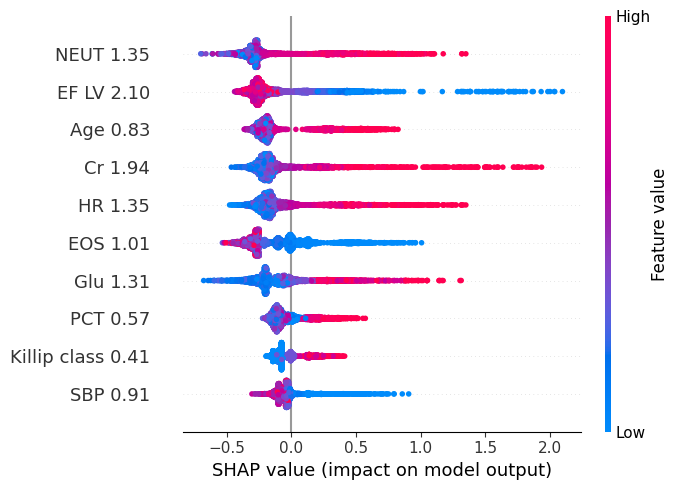

In [ ]:
#Displaying the overall SHAP graph
def generalGraphShap(features,result,dataset):

                      #Clearing a data set of omissions
    features.append(result)
    model_data = dataset[features]
    model_data = model_data.dropna()
    features.remove(result)

    m_data = dataset[features]
    x_all = np.array(model_data[features])
    y_all = np.array(model_data[result].astype('int'))

    rm=42
    np.random.seed(rm)

    model = xgb.XGBClassifier(
                                  learning_rate=0.1,  eval_metric = "auc",
                                  scale_pos_weight = 1,    max_depth=3,  n_estimators=50,  random_state=rm,
                                  verbosity=0 , objective= 'binary:logistic', booster= 'gbtree',
                                  tree_method ='exact', max_delta_step=3, gamma=1, min_child_weight=2,
                                  subsample=0.5, colsample_bylevel=1,
                                  n_jobs=-1
                              )
                        #Model Training
    model.fit(x_all, y_all)
    explainer = shap.TreeExplainer(model)
                        #Calculation of SHAP value
    shap_values = explainer.shap_values(model_data[features])
    shap_values_df=pd.DataFrame(shap_values)
    names=[]
                        #Specifying SHAP value in column names
    for i in  range(len(model_data[features].columns)):
            name=model_data[features].columns[i] + " {:.2f}".format( max(shap_values_df[i]))
            names.append(name)
                        #Displaying a SHAP graph
    summary = shap.summary_plot(shap_values,  model_data[features],
                                    feature_names=names,
                                    plot_type='dot',
                                    plot_size=(7,5),
                                    show=False,
                                  )


features=['Age','HR', 'SBP' ,'Killip class' ,'EF LV',
            'Cr' ,'NEUT','EOS',
            'PCT','Glu']
result = 'Dead'
generalGraphShap(features,result,dataset)

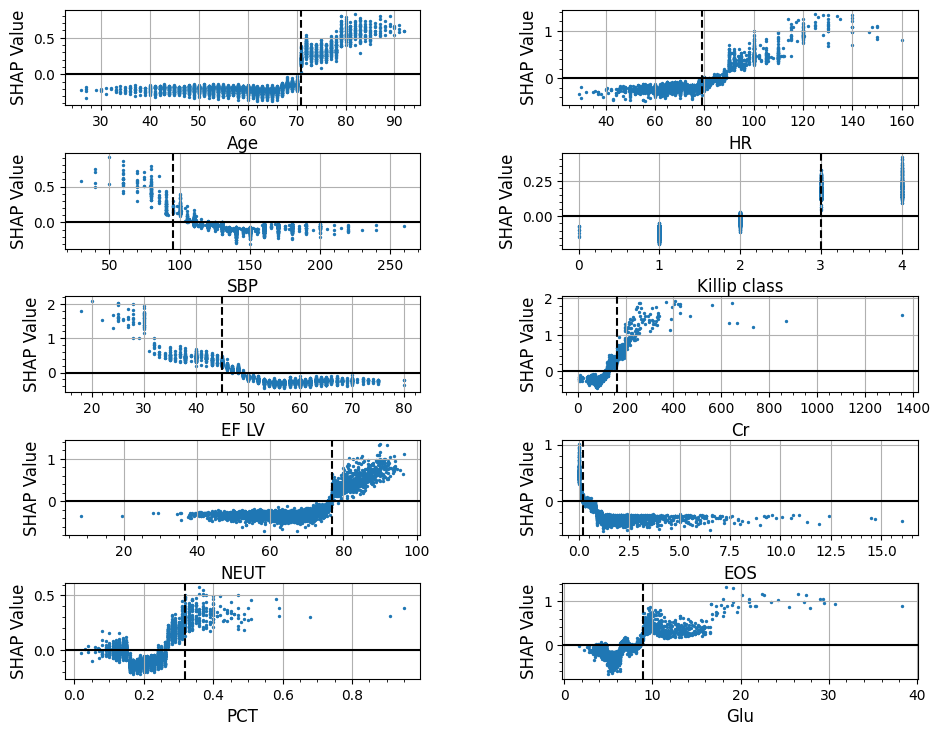

In [ ]:
#Displaying a detailed SHAP graph
def detailedGraphSHAP( features, result, dataset, thresholds, figsize=(11,18), dpi=100, fontsize = 12):

                      #Clearing a data set of omissions
    features.append(result)
    model_data = dataset[features]
    model_data = model_data.dropna()
    features.remove(result)

    m_data = dataset[features]
    x_all = np.array(model_data[features])
    y_all = np.array(model_data[result].astype('int'))

    rm = 42
    np.random.seed(rm)

    model = xgb.XGBClassifier(learning_rate=0.1,  eval_metric = "auc",
                                  scale_pos_weight = 1,    max_depth=3,  n_estimators=50,  random_state=rm,
                                  verbosity=0 , objective= 'binary:logistic', booster= 'gbtree',
                                  tree_method ='exact', max_delta_step=3, gamma=1, min_child_weight=2,
                                  subsample=0.5, colsample_bylevel=1,
                                  n_jobs=-1
                                  )
                        #Model Training
    model.fit(x_all, y_all)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(model_data[features])
    shap_values_df=pd.DataFrame(shap_values)

    plt.figure(figsize=figsize,dpi = dpi)
                        #Displaying multiple SHAP graphs
    count_row = len(features)/2
    for predictor in range(0,len(features)):
          plt.subplot(len(features), 2, predictor+1)
          plt.subplots_adjust(wspace=0.4, hspace=0.5)
          plt.minorticks_on()
          plt.grid()
          plt.scatter(  model_data[features[predictor]],shap_values_df[predictor], s = 2  )
          plt.xlabel(features[predictor],fontsize=fontsize)
          plt.ylabel('SHAP Value',fontsize=fontsize)
          plt.axhline(y=0, color='black')
          plt.axvline(x=thresholds[predictor], color='black', linestyle='--')

thresholds = [  71,    79,   95,    3,              45,      166,  77,     0.2,   0.32,  8.9,     ]
features=    [  'Age', 'HR', 'SBP', 'Killip class' ,'EF LV', 'Cr' ,'NEUT', 'EOS', 'PCT', 'Glu']
result = 'Dead'
detailedGraphSHAP( features, result, dataset, thresholds )

Formation of the "Risk Factors" table

In [ ]:
#Calculation of centroids
def getRiskFactorCentroid( dataset, x, y ):
    try:
      array_threshold_value = []
      x_y = pd.DataFrame()
      x_y[x] = dataset[x]
      x_y[y] = dataset[y]
      x_y = x_y.dropna()

      group_1 = x_y.loc[(x_y[y] == 1)]
      group_0 = x_y.loc[(x_y[y] == 0)]

      group_1_median = median( group_1[x] ) #Calculation of the median of the dead
      group_0_median = median( group_0[x] ) #Calculation of median survivors

      return (group_1_median+group_0_median)/2 #Calculation of the average value
    except Exception as err:
        return None

                                              #Calculation of risk factor metrics
def getDataAnalys( dataset, x ,y, group_1_all, group_0_all, group_1_part, group_0_part ):
      try:
        data_crosstab = pd.crosstab(dataset[y],
                                    dataset[x])
                                              #Calculation of p-value and OR
        if( data_crosstab.shape == (2, 2) ):
                  chi2, p_value, df, expected = chi2_contingency(data_crosstab)
                  odd_ratio, p = stats.fisher_exact(data_crosstab)
                  table = Table2x2(data_crosstab, shift_zeros=False)
                  confint = table.oddsratio_confint()

        skf = StratifiedKFold(n_splits=5)
        auc_array = []
                                              #Calculation of AUC
        for train,test in skf.split(dataset[x],dataset[y]):

          result = getLogisticRegression(  dataset[y].iloc[train].values.reshape(-1, 1), dataset[x].iloc[train].values.reshape(-1, 1),
                                                                               dataset[y].iloc[test].values.reshape(-1, 1),  dataset[x].iloc[test].values.reshape(-1, 1) )
          if( result["metrics"] != None ):
            auc_array.append( result["metrics"]["auc"] )
                                              #Calculation of Weight
        logistReg_min = LogisticRegression()
        logistReg_min.fit( dataset[x].values.reshape(-1, 1) , dataset[y].values.reshape(-1, 1).ravel() )

        group_1 = dataset.loc[(dataset[x] == 1)]
        group_1_count = sum(group_1[y])
        group_0_count = len( group_1[y] ) - group_1_count

        return {
                                      "p-value chi2":p_value,
                                      "OR":odd_ratio,
                                      "OR CI":"{0:.3f}[{1:.3f};{2:.3f}]".format(odd_ratio,confint[0],confint[1]),
                                      "OR min":confint[0],
                                      "OR max":confint[1],
                                      "Weight":logistReg_min.coef_[0][0],
                                      "Auc":median(auc_array),
                                      "Group 1(all dataset)":"{0}({1:.3f}%)".format( group_1_count,float(float(group_1_count)/float(group_1_all)*100) ),
                                      "Group 0(all dataset)":"{0}({1:.3f}%)".format( group_0_count,float(group_0_count/group_0_all*100) ),
                                      "Group 1(this dataset)":"{0}({1:.3f}%)".format( group_1_count,float(float(group_1_count)/float(group_1_part)*100) ),
                                      "Group 0(this dataset)":"{0}({1:.3f}%)".format( group_0_count,float(group_0_count/group_0_part*100) ),
                }
      except Exception as err:
        return None

                                  #Obtaining a risk factor
def getRow( dataset, x, option, y, value, group_1_all, group_0_all ):

    dead_count = sum(dataset[y])
    survived_count = len(dataset[y]) - dead_count

    if( option == "<" ):          #If "<" is specified, then calculate the risk factor less than the cut-off threshold
      dataset[x+"binary"] = 0
      dataset.loc[((dataset[x])<value),(x+"binary")]=1
      data = getDataAnalys( dataset, x+"binary" ,y, group_1_all, group_0_all,dead_count,survived_count )

    if( option == ">" ):         #If ">" is specified, then calculate the risk factor greater than the cut-off threshold
      dataset[x+"binary"] = 0
      dataset.loc[((dataset[x])>value),(x+"binary")]=1
      data = getDataAnalys( dataset, x+"binary" ,y, group_1_all, group_0_all,dead_count,survived_count )

    if( data == None ):
        return None

    return {                        "Threshold":value,
                                    "Died in the dataset":dead_count,
                                    "Survived in the dataset":survived_count,
                                    "p-value chi2":data["p-value chi2"],
                                    "OR":data["OR"],
                                    "OR CI":data["OR CI"],
                                    "OR min":data["OR min"],
                                    "OR max":data["OR max"],
                                    "Auc":data["Auc"],
                                    "Group 1(all dataset)":data["Group 1(all dataset)"],
                                    "Group 0(all dataset)":data["Group 0(all dataset)"],
                                    "Group 1(this dataset)":data["Group 1(this dataset)"],
                                    "Group 0(this dataset)":data["Group 0(this dataset)"],
                                    }

                            #Iterating over the predictor values and considering them as potential predictors
def getThresholdValue( dataset, x, option, y, list_unique_value = None  ):
    array_threshold_value = []
    x_y = pd.DataFrame()
    x_y[x] = dataset[x]
    x_y[y] = dataset[y]

    group_1_all = sum(x_y[y])
    group_0_all = len( x_y[y] ) - group_1_all

    x_y[x+"binary"] = 0
    x_y = x_y.dropna()
    if list_unique_value == None:
      list_unique_value = pd.unique(x_y[x])
    for value in tqdm(list_unique_value):

        row = getRow( x_y, x, option, y, value, group_1_all, group_0_all  )
        if row != None:
            array_threshold_value.append(row)
    return array_threshold_value

                          #Calculation of a row for a table of risk factors
def getRowTableRiskFactor( x, option, table_threshold_value, method ):

      try:
        n = 0                     #If the method is "Max OR", then get a significant risk factor with a maximum OR
        if( method == "Max OR" ):

            table_threshold_value = table_threshold_value.sort_values(by=['OR'],ascending=False)

            for i in range( 0,len(table_threshold_value['OR']) ):
              if( table_threshold_value['OR min'].values[i]>1 and table_threshold_value['OR max'].values[i]>1 ):
                n = i
                break
                                  #If the method is "Min p-value", then get a significant risk factor with a minimum p-value
        if( method == "Min p-value" ):
              table_threshold_value = table_threshold_value.sort_values(by=['p-value chi2'])
                                  #If the method is "Min p-value", then get a significant risk factor with maximum AUC
        if( method == "Max AUC" ):
            table_threshold_value = table_threshold_value.sort_values(by=['Auc'],ascending=False)

                                  #If the method is "Centroid", then do not process the data
        if( method == "Centroid" ):
              table_threshold_value = table_threshold_value


        return {    "Predictor":x,
                    "Died in the dataset":table_threshold_value["Died in the dataset"].values[n],
                    "Survived in the dataset":table_threshold_value["Survived in the dataset"].values[n],
                    "Method":method,
                    "Threshold": "{0}".format((table_threshold_value["Threshold"].values[n]))+option,
                    "Group 1(all dataset)":table_threshold_value["Group 1(all dataset)"].values[n],
                    "Group 0(all dataset)":table_threshold_value["Group 0(all dataset)"].values[n],
                    "Group 1(this dataset)":table_threshold_value["Group 1(this dataset"].values[n],
                    "Group 0(this dataset)":table_threshold_value["Group 0(this dataset)"].values[n],
                    "p-value": "{0:.8f}".format( table_threshold_value["p-value chi2"].values[n]),
                    "OR CI(95%)": table_threshold_value["OR CI"].values[n],
                    "AUC":"{0:.3f}".format(table_threshold_value["Auc"].values[n])}

      except Exception as err:
        return None
                          #Calculation of the final table of risk factors
def getTableRiskFactor(  dataset, x_array, options, y ):

    table_risk_factor = []
                          #For each predictor, calculate the risk factors using different methods
    for i in range(0,len(x_array)):
      x = x_array[i]
      option = options[i]
      print("Predictor processing \""+x+"\"")
      table_threshold_value = getThresholdValue(dataset, x, option, y)
      table_threshold_value = pd.DataFrame(table_threshold_value)
      row = getRowTableRiskFactor(x,option,table_threshold_value,"Max ОШ")
      if( row != None ):
        table_risk_factor.append( row )
      row = getRowTableRiskFactor(x,option,table_threshold_value,"Min p-value")
      if( row != None ):
        table_risk_factor.append( row )

      row = getRowTableRiskFactor(x,option,table_threshold_value,"Max AUC")
      if( row != None ):
        table_risk_factor.append( row )

      value = getRiskFactorCentroid( dataset, x, y )
      if( value != None ):
        table_threshold_value = getThresholdValue(dataset, x, option, y, [value])
        table_threshold_value = pd.DataFrame(table_threshold_value)
        row = getRowTableRiskFactor(x,option,table_threshold_value,"Centroid")
        if( row != None ):
          table_risk_factor.append( row )

    return table_risk_factor


table = getTableRiskFactor(dataset, ["Age", "HR", "Killip class", "Cr", "EF LV", "NEUT","EOS", "PCT", "Glu", "SBP"]
                                    [">",   ">",  ">",            ">",  "<",     ">",   "<",   ">",   ">",   "<",], "Dead")
pd.DataFrame(table).to_excel(table,path_table_risk_factor)